# Assignment 1
## Part 1: Byte Pair Encoding

### Import Required Packages

In [16]:
import re
import os
import json
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize


import nltk
nltk.download('punkt')
from nltk.corpus import gutenberg
nltk.download('gutenberg')

[nltk_data] Downloading package punkt to /Users/zihanwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/zihanwang/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

##### Get the list of available books in the Gutenberg Corpus

In [3]:
book_list = gutenberg.fileids()
print("Available Books:")
for book in book_list:
    print(book)

Available Books:
austen-emma.txt
austen-persuasion.txt
austen-sense.txt
bible-kjv.txt
blake-poems.txt
bryant-stories.txt
burgess-busterbrown.txt
carroll-alice.txt
chesterton-ball.txt
chesterton-brown.txt
chesterton-thursday.txt
edgeworth-parents.txt
melville-moby_dick.txt
milton-paradise.txt
shakespeare-caesar.txt
shakespeare-hamlet.txt
shakespeare-macbeth.txt
whitman-leaves.txt


### 1. Implement BPE Algorithm

```preprocess_and_create_vocab```: preprocess the input texts and creating an initial vocabulary.

```get_stats```: compute the frequencies of adjacent character pairs (byte pairs) in the vocabulary.

```merge_vocab```: merge the most frequent byte pair in the vocabulary.

```encode_text```: encode new texts using the learned BPE merges.

```decode_text```: reverse the BPE encoding process and reconstruct the original text.

In [4]:
def preprocess_and_create_vocab(texts):
    vocab = Counter()
    for text in texts:
        words = text.split()
        for word in words:
            word = ' '.join(list(word)) + ' </w>'
            vocab[word] += 1
    return vocab

def get_stats(vocab):
    pairs = Counter()
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, vocab):
    new_vocab = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in vocab:
        w_out = p.sub(''.join(pair), word)
        new_vocab[w_out] = vocab[word]
    return new_vocab

def encode_text(text, vocab):
    """Encode a text using the BPE vocab."""
    words = text.split()
    encoded_text = []
    for word in words:
        word = ' '.join(list(word)) + ' </w>'
        while len(word.split()) > 1:
            pairs = get_stats({word: 1})
            if not pairs:
                break
            best = max(pairs, key=pairs.get)
            word = merge_vocab(best, {word: 1}).popitem()[0]
        encoded_text.append(word)
    return encoded_text

def decode_text(encoded_text):
    """Decode a text using the BPE encoding."""
    decoded_text = ' '.join(encoded_text).replace('</w>', '').replace(' ', '')
    return decoded_text

### 2. Train on NLTK Dataset

Books chosen: austen-emma.txt, blake-poems.txt, shakespeare-hamlet.txt


In [5]:
train_books = ['austen-emma.txt', 'blake-poems.txt', 'shakespeare-hamlet.txt']
train_texts = [gutenberg.raw(book) for book in train_books]
original_vocab = preprocess_and_create_vocab(train_texts)

In [6]:
num_merges = 3000
vocab = original_vocab.copy()
merge_frequencies = []

for i in range(num_merges):
    pairs = get_stats(vocab)
    if not pairs:
        break
    best = max(pairs, key=pairs.get)
    best_frequency = pairs[best]
    merge_frequencies.append(best_frequency)
    vocab = merge_vocab(best, vocab)

### 3. Test on NLTK Dataset

Books chosen: austen-sense.txt, austen-persuasion.txt, edgeworth-parents.txt

Note: the similarity between training books and testing books can influence the result of evaluation metrics

In [7]:
# Load and preprocess test data
test_books = ['austen-sense.txt', 'austen-persuasion.txt', 'edgeworth-parents.txt']
test_texts = [gutenberg.raw(book) for book in test_books]
test_vocab = preprocess_and_create_vocab(test_texts)

# Encode the test texts
encoded_texts = [encode_text(text, vocab) for text in test_texts]


Evaluate metrics: Coverage, Accuracy

In [8]:
# Coverage
training_tokens = set(vocab.keys())
test_tokens = set(sum(encoded_texts, []))
coverage = len(training_tokens & test_tokens) / len(test_tokens)

print(f"Coverage: {coverage:.2%}")

Coverage: 3.33%


In [9]:
# Measure accuracy
accuracies = []
for original_text, encoded_text in zip(test_texts, encoded_texts):
    decoded_text = decode_text(encoded_text)
    # Simple accuracy: percentage of correctly reconstructed characters
    correct_chars = sum(o == d for o, d in zip(original_text, decoded_text))
    total_chars = len(original_text)
    accuracy = correct_chars / total_chars
    accuracies.append(accuracy)

average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy: {average_accuracy:.2%}")


Average Accuracy: 3.71%


Tokenization coverage of the BPE algorithm is 3.33%

Tokenization accuracy of the BPE algorithm is 3.71%

#### Saving books as text files

In [17]:
def save_book(book_id, file_path):
    text = gutenberg.raw(book_id)
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(text)

# Directory where you want to save the books
train_path = 'training_texts'
test_path = 'testing_texts'

# Training and Test Books
train_books = ['austen-emma.txt', 'blake-poems.txt', 'shakespeare-hamlet.txt']
test_books = ['austen-sense.txt', 'austen-persuasion.txt', 'edgeworth-parents.txt']

# Saving Books
for book in train_books:
    file_path = os.path.join(train_path, book)
    save_book(book, file_path)
    print(f"Saved {book} to {file_path}")

for book in test_books:
    file_path = os.path.join(test_path, book)
    save_book(book, file_path)
    print(f"Saved {book} to {file_path}")

Saved austen-emma.txt to training_texts/austen-emma.txt
Saved blake-poems.txt to training_texts/blake-poems.txt
Saved shakespeare-hamlet.txt to training_texts/shakespeare-hamlet.txt
Saved austen-sense.txt to testing_texts/austen-sense.txt
Saved austen-persuasion.txt to testing_texts/austen-persuasion.txt
Saved edgeworth-parents.txt to testing_texts/edgeworth-parents.txt


### 4. Create Reference Tokenization with punkt

Use NLTK's punkt tokenizer to create a reference tokenization for the test dataset. 

In [10]:
def tokenize_with_punkt(text):
    """Tokenize text using Punkt Sentence Tokenizer and NLTK's word tokenizer."""
    sentence_tokenizer = PunktSentenceTokenizer()
    sentences = sentence_tokenizer.tokenize(text)
    word_tokens = [word_tokenize(sentence) for sentence in sentences]
    return word_tokens

In [11]:
# Tokenize the test texts
punkt_tokenized_texts = [tokenize_with_punkt(text) for text in test_texts]

def save_as_txt(tokenized_texts, file_path):
    with open(file_path, 'w') as f:
        for text in tokenized_texts:
            for sentence in text:
                f.write(' '.join(sentence) + '\n')
            f.write('\n')  # Separate documents by a blank line

# Save the Punkt tokenized texts
punkt_file_path = 'tokenization_result/punkt_tokenized_texts.txt'
save_as_txt(punkt_tokenized_texts, punkt_file_path)

print(f"Punkt tokenized texts saved to {punkt_file_path}")


Punkt tokenized texts saved to tokenization_result/punkt_tokenized_texts.txt


In [12]:
def save_bpe_encoded(encoded_texts, file_path):
    with open(file_path, 'w') as f:
        for text in encoded_texts:
            for token in text:
                f.write(token + '\n')
            f.write('\n')

# Save the BPE encoded texts
bpe_file_path = 'tokenization_result/bpe_encoded_texts.txt'
save_bpe_encoded(encoded_texts, bpe_file_path)

print(f"BPE encoded texts saved to {bpe_file_path}")

BPE encoded texts saved to tokenization_result/bpe_encoded_texts.txt


### 5. Compare with Standard Tokenization: Word Tokenization

In [13]:
# Tokenize the test texts using NLTK's word_tokenize
nltk_tokenized_texts = [word_tokenize(text) for text in test_texts]

In [14]:
def calculate_metrics(bpe_tokens, nltk_tokens):
    # Flatten the lists of tokens
    flat_bpe_tokens = [token for sublist in bpe_tokens for token in sublist]
    flat_nltk_tokens = [token for sublist in nltk_tokens for token in sublist]

    # Metrics calculation
    true_positives = len(set(flat_bpe_tokens) & set(flat_nltk_tokens))
    false_positives = len(set(flat_bpe_tokens) - set(flat_nltk_tokens))
    false_negatives = len(set(flat_nltk_tokens) - set(flat_bpe_tokens))

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    jaccard_similarity = true_positives / (true_positives + false_positives + false_negatives) if true_positives + false_positives + false_negatives > 0 else 0

    return true_positives, false_positives, false_negatives, precision, recall, f1_score, jaccard_similarity


In [15]:
# precision, recall, F1-score, and Jaccard similarity for each test text
for i, (bpe_text, nltk_text) in enumerate(zip(encoded_texts, nltk_tokenized_texts)):
    true_positives, false_positives, false_negatives, precision, recall, f1_score, jaccard_similarity = calculate_metrics(bpe_text, nltk_text)
    print(f"Text {i+1}:")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}, Jaccard Similarity: {jaccard_similarity:.2f}")
    print(f"True Positive: {true_positives:.2f}, False Positive: {false_positives:.2f}, False Negative: {false_negatives:.2f}")


Text 1:
Precision: 0.96, Recall: 0.99, F1-Score: 0.97, Jaccard Similarity: 0.95
True Positive: 75.00, False Positive: 3.00, False Negative: 1.00
Text 2:
Precision: 0.95, Recall: 1.00, F1-Score: 0.97, Jaccard Similarity: 0.95
True Positive: 75.00, False Positive: 4.00, False Negative: 0.00
Text 3:
Precision: 0.95, Recall: 0.99, F1-Score: 0.97, Jaccard Similarity: 0.94
True Positive: 76.00, False Positive: 4.00, False Negative: 1.00


In [15]:
def calculate_coverage(bpe_tokens, nltk_tokens):
    flat_bpe_tokens = [token for sublist in bpe_tokens for token in sublist]
    flat_nltk_tokens = [token for sublist in nltk_tokens for token in sublist]

    unique_bpe_tokens = set(flat_bpe_tokens)
    unique_nltk_tokens = set(flat_nltk_tokens)
    coverage = len(unique_bpe_tokens & unique_nltk_tokens) / len(unique_nltk_tokens) if unique_nltk_tokens else 0

    return coverage

for i, (bpe_text, nltk_text) in enumerate(zip(encoded_texts, nltk_tokenized_texts)):
    coverage = calculate_coverage(bpe_text, nltk_text)
    print(f"Text {i+1}: Coverage: {coverage:.2f}")

Text 1: Coverage: 0.99
Text 2: Coverage: 1.00
Text 3: Coverage: 0.99


##### Evaluation of the three test texts:
Text 1(austen-sense.txt): 
- Precision: 0.96
- Recall: 0.99
- F1-Score: 0.97
- Jaccard Similarity: 0.95
- Coverage: 0.99

Text 2(austen-persuasion.txt):
- Precision: 0.95
- Recall: 1.00
- F1-Score: 0.97
- Jaccard Similarity: 0.95
- Coverage: 1.00

Text 3(edgeworth-parents.txt):
- Precision: 0.95
- Recall: 0.99
- F1-Score: 0.97
- Jaccard Similarity: 0.94
- Coverage: 0.99


**Precision** assesses the accuracy of the positive predictions made by BPE algorithm. In the context of tokenization, it measures the proportion of tokens identified by BPE algorithm that are correct according to the reference tokenization. 
- High precision means that most of the tokens BPE algorithm identifies are indeed valid tokens. This is important for ensuring that algorithm isn't overly aggressive in tokenizing text, which could lead to fragmented or nonsensical tokens.

**Recall** evaluates the ability of BPE algorithm to capture all the relevant instances. It's the proportion of actual tokens in the ground truth that your algorithm successfully identifies. 
- High recall indicates that BPE algorithm is effective in identifying most of the tokens present in the text. This is crucial for ensuring that the algorithm doesn't miss out on important tokens, which could lead to loss of information or context in downstream tasks.

**F1-Score** is the mean of precision and recall. It provides a single metric that balances both precision and recall.The F1-Score is useful for finding a balance between precision and recall. 
It's helpful if there's an uneven class distribution (like when some tokens are much more common than others), as it doesn't disproportionately favor a large number of correct but trivial predictions.

**Jaccard Similarity** measures the similarity between the set of tokens produced by BPE algorithm and the set in the ground truth. It's calculated as the size of the intersection divided by the size of the union of the two sets of tokens. 
- Jaccard Similarity gives a sense of the overall similarity between the two sets of tokens. It's useful for understanding how closely BPE tokens match the reference tokens in terms of both presence and absence of tokens.

**Coverage** evaluates the proportion of unique tokens in the ground truth that are covered by BPE algorithm. Coverage is important for assessing the comprehensiveness of BPE algorithm. 
- A high coverage indicates that the BPE algorithm is capable of representing a wide range of tokens in the text, which is essential for ensuring the utility of the algorithm in diverse text processing scenarios.

### 6. Visualizations

##### a. Visualizing the Frequency of Most Common Merge

In [14]:
import matplotlib.pyplot as plt
from collections import defaultdict

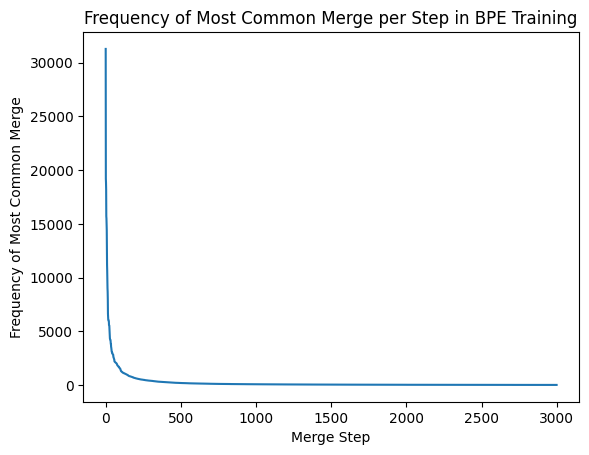

In [18]:

plt.plot(merge_frequencies)
plt.xlabel('Merge Step')
plt.ylabel('Frequency of Most Common Merge')
plt.title('Frequency of Most Common Merge per Step in BPE Training')
plt.show()

This plot shows the frequencies of the most common pair merge in each step. \
From the plot, we see high frequencies at the beginning (as common pairs are merged) which may decrease as the algorithm progresses and fewer common pairs are available to merge.

##### Visualizing Top Tokens of Byte Pair Encoding

In [19]:
def get_top_tokens(vocab, top_n=10):
    """Get the top N tokens from the vocabulary."""
    # Sort the vocabulary items by frequency in descending order
    sorted_vocab = sorted(vocab.items(), key=lambda item: item[1], reverse=True)
    return sorted_vocab[:top_n]


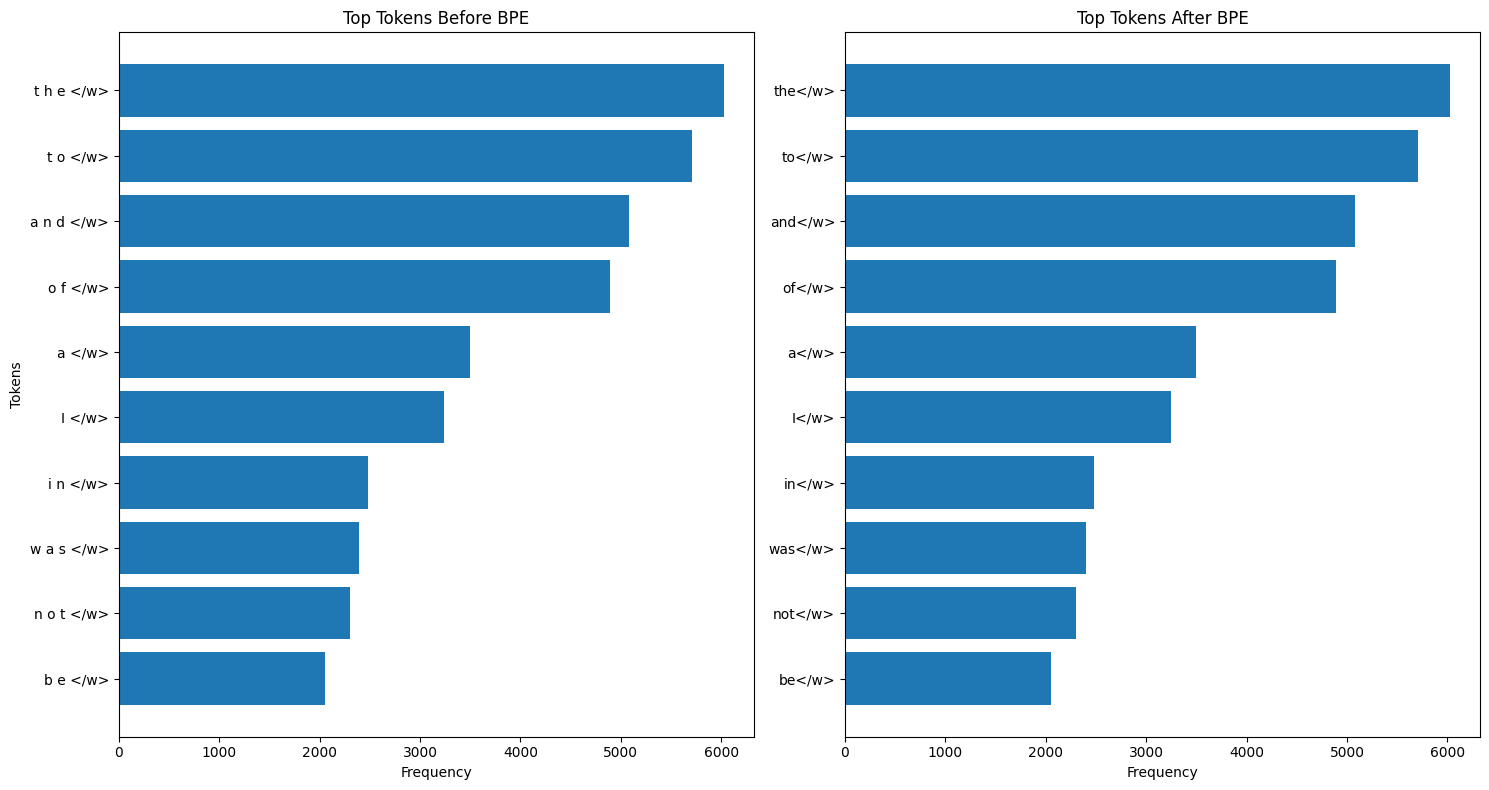

In [24]:
top_n = 10
initial_top_tokens = get_top_tokens(original_vocab, top_n)
final_top_tokens = get_top_tokens(vocab, top_n)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Reverse the order for initial vocabulary
tokens, frequencies = zip(*reversed(initial_top_tokens))
axes[0].barh(tokens, frequencies)
axes[0].set_title('Top Tokens Before BPE')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Tokens')

# Reverse the order for final vocabulary
tokens, frequencies = zip(*reversed(final_top_tokens))
axes[1].barh(tokens, frequencies)
axes[1].set_title('Top Tokens After BPE')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

